In [1]:
import h5py
import numpy as np
from astropy.io import ascii
import matplotlib.pyplot as plt

In [18]:
cutouts = h5py.File('/srv/scratch/mltidal/generated_data_experiment.hdf')
keys = ascii.read('/srv/scratch/z5214005/lrgs_sampled.tbl')['new_ids']

In [19]:
fracs = np.zeros(len(keys))
for i, key in enumerate(keys):
    fracs[i] = cutouts[key]['FRAC'][()]

In [4]:
real_fracs = np.load('/srv/scratch/z5214005/precalc_fracs/fracs.npy')[2]

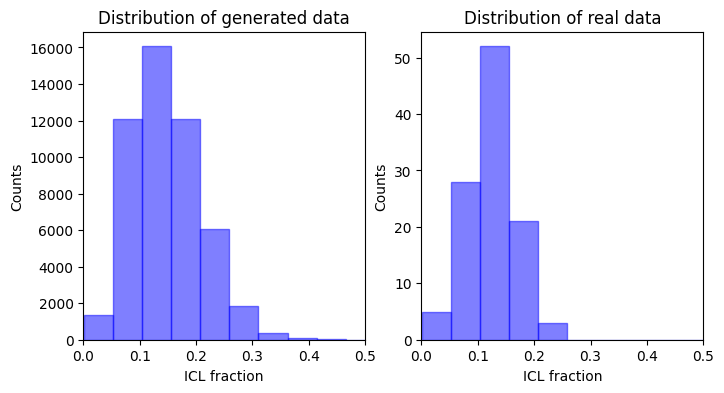

In [9]:
plt.figure(figsize=(8,4))
plt.subplot(121)
_, bins, _ = plt.hist(fracs, bins=15, facecolor='b', alpha=0.5, edgecolor='b')
plt.title('Distribution of generated data')
plt.xlabel('ICL fraction')
plt.ylabel('Counts')
plt.xlim(0, 0.5)
plt.subplot(122)
plt.hist(real_fracs, bins=bins, facecolor='b', alpha=0.5, edgecolor='b')
plt.title('Distribution of real data')
plt.xlabel('ICL fraction')
plt.ylabel('Counts')
plt.xlim(0, 0.5)
plt.show()

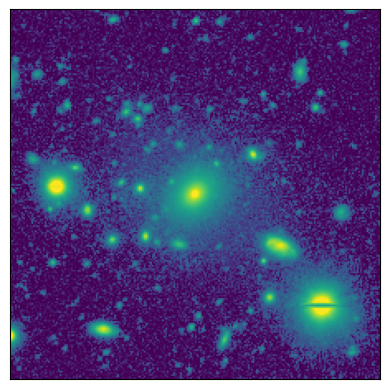

In [19]:
from data.scripts.display_cutouts import stretch

cutout = cutouts[keys[200]]['HDU0']['DATA']
plt.imshow(stretch(cutouts[keys[200]]['HDU0']['DATA']))
plt.xticks([])
plt.yticks([])
plt.show()

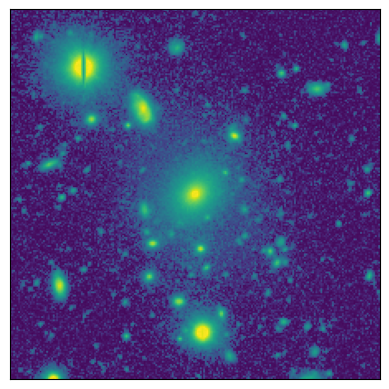

In [44]:
from augmentations import *

def augmenter(input_shape, mean=0.948, std=1.108):
    return keras.Sequential(
        [
            layers.Input(shape=input_shape),
            # layers.Normalization(mean=mean, variance=std**2),
            layers.RandomFlip(mode='horizontal_and_vertical'),
            RandomGaussianNoise(stddev=0.017359),
            RandomRotate90(),
        ]
    )

aug = augmenter((224,224,1))
img = np.clip(cutout, a_min=0, a_max=10)
img = np.arcsinh(img / 0.017359)
img = np.expand_dims(img, 0)
img = np.expand_dims(img, -1)
new_img = aug(img)
plt.imshow(new_img.numpy().squeeze())
plt.xticks([])
plt.yticks([])
plt.show()

(-2.79, 49.79, -0.9829377722150682, 1.0771393391105113)

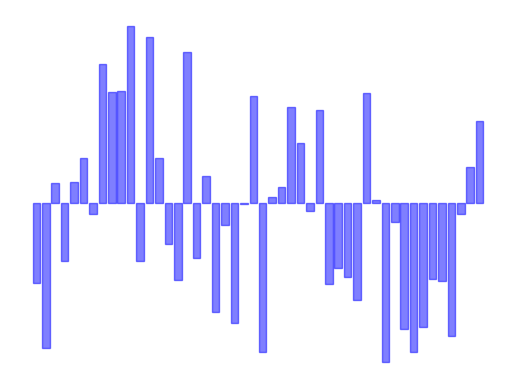

In [53]:
random_vector = 2 * np.random.rand(48) - 1
plt.bar(np.arange(48), random_vector, facecolor='b', alpha=0.5, edgecolor='b')
plt.xticks([])
plt.yticks([])
plt.gca().axis('off')

In [2]:
from supervised_model_prob import ImageRegressor, prepare_data

ds, vd = prepare_data()
model = ImageRegressor((224,224,1))
model.load_weights('checkpoint-sup-expdatacont2-final.ckpt').expect_partial()

2023-10-12 20:03:41.880708: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-12 20:03:42.460024: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 20:03:52.658296: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/srv/scratch/z5214005/miniconda3/envs/tf2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook impo

2023-10-12 16:17:11.959210: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [128]
	 [[{{node Placeholder/_1}}]]
2023-10-12 16:17:11.959530: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [128]
	 [[{{node Placeholder/_1}}]]


2023-10-12 16:17:37.428942: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [45000]
	 [[{{node Placeholder/_1}}]]
2023-10-12 16:17:50.540842: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [45000]
	 [[{{node Placeholder/_1}}]]


Text(0.5, 0, 'ICL Fraction')

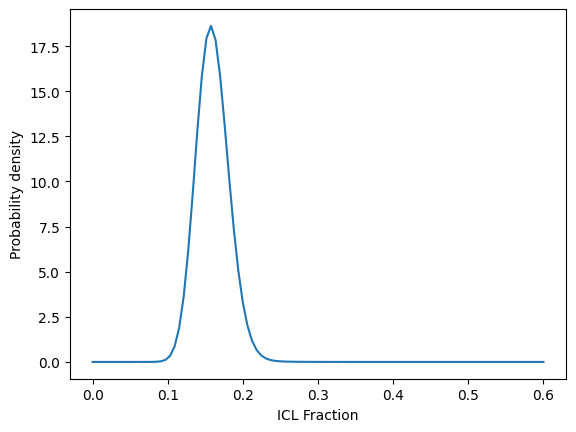

In [5]:
for batch in ds:
    outputs = model(batch[0]) 
    break

x = np.linspace(0, 0.6, 100)
logps = []

for i in x:
    logps.append(outputs.log_prob(i).numpy())
logps = np.stack(logps)

plt.plot(x, np.exp(logps[:,0]))
plt.ylabel('Probability density')
plt.xlabel('ICL Fraction')

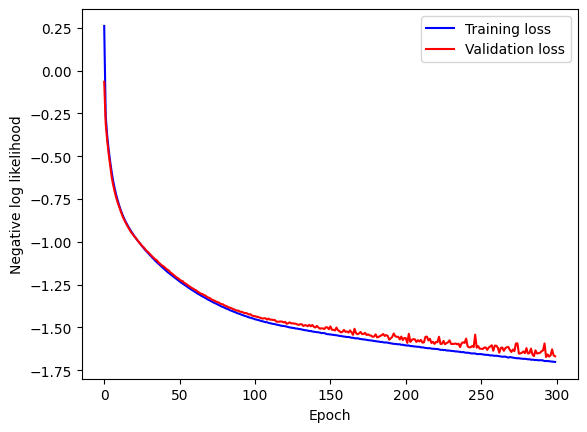

In [11]:
files = [4920053, 4922128, 4922586]

loss = []
val_loss = []
for jobnumber in files:
    f = open(f'sup_train.pbs.o{jobnumber}')
    for line in f:
        words = line.split(' ')
        if 'loss:' in words:
            loss.append(float(words[7]))
            val_loss.append(float(words[-1]))

plt.plot(loss, color='b')
plt.plot(val_loss, color='r')
plt.legend(['Training loss', 'Validation loss'])
plt.ylabel('Negative log likelihood')
plt.xlabel('Epoch')
plt.show()

In [14]:
from supervised_model_prob import binned_plot

x = np.arange(0, 1, 0.001)

predictions = []
for batch in vd:
    outputs = model(batch[0])
    logps = []
    for i in x:
        logps.append(outputs.log_prob(i).numpy())
    logps = np.stack(logps)
    predictions.append(x[np.exp(logps).argmax(axis=0)])
predictions = np.array(predictions).flatten()

# Create binned plot
binned_plot(vd, predictions, n=20, percentiles=[35,45,50], color='b', filename=f'binned_plot-mode.png')


2023-10-12 17:01:55.615571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [5000]
	 [[{{node Placeholder/_1}}]]


MAE = 0.023414960525039795


(array([(0.03755, 0.06635, 0.034  , 0.08745, 0.0455),
        (0.05   , 0.088  , 0.046  , 0.11025, 0.0655),
        (0.068  , 0.104  , 0.059  , 0.1256 , 0.083 ),
        (0.081  , 0.12125, 0.07   , 0.141  , 0.1   ),
        (0.097  , 0.143  , 0.08145, 0.16265, 0.1195),
        (0.109  , 0.16235, 0.091  , 0.18   , 0.1365),
        (0.121  , 0.18   , 0.09695, 0.19605, 0.155 ),
        (0.1398 , 0.1982 , 0.1216 , 0.2134 , 0.176 ),
        (0.151  , 0.213  , 0.1292 , 0.2286 , 0.19  ),
        (0.159  , 0.231  , 0.1399 , 0.2441 , 0.204 ),
        (0.1629 , 0.2461 , 0.14   , 0.2664 , 0.212 ),
        (0.182  , 0.27335, 0.16865, 0.29345, 0.2335),
        (0.18975, 0.285  , 0.148  , 0.299  , 0.241 ),
        (0.1805 , 0.28195, 0.1659 , 0.30865, 0.2295),
        (0.21   , 0.2686 , 0.1981 , 0.2873 , 0.258 ),
        (0.2604 , 0.376  , 0.2448 , 0.386  , 0.317 ),
        (0.245  , 0.288  , 0.231  , 0.296  , 0.273 ),
        (0.31145, 0.36955, 0.30315, 0.37785, 0.3405),
        (0.3127 , 0.3813 , 0

2023-10-12 18:25:13.293697: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [5000]
	 [[{{node Placeholder/_1}}]]


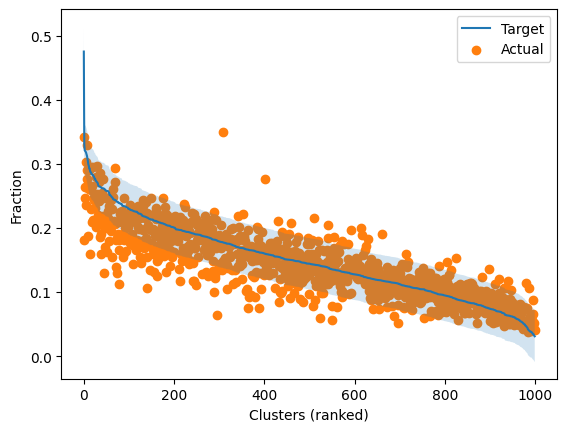

In [5]:
unbatched = vd.unbatch()

x = np.arange(0, 1, 0.001)
predictions = []
for batch in vd:
    outputs = model(batch[0])
    logps = []
    for i in x:
        logps.append(outputs.log_prob(i).numpy())
    logps = np.stack(logps)
    predictions.append(x[np.exp(logps).argmax(axis=0)])
predictions = np.array(predictions).flatten()

# Grab the first 1000 elements for plotting
labels = []
for i, thing in enumerate(unbatched):
    if i == 1000:
        break
    labels.append(thing[1])
labels = np.array(labels)

ordered = np.argsort(labels)[::-1]

plt.plot(np.arange(0, len(labels)), labels[ordered])
plt.scatter(np.arange(0, len(labels)), predictions[ordered], color='C1')
plt.fill_between(np.arange(0, len(labels)), labels[ordered]-0.04, labels[ordered]+0.04, alpha=0.2)
plt.legend(['Target', 'Actual'])
plt.xlabel('Clusters (ranked)')
plt.ylabel('Fraction') 
plt.show()

In [18]:
# unbatched = vd.unbatch()

# x = np.arange(0, 1, 0.001)
# predictions = []
# for batch in vd:
#     outputs = model(batch[0])
#     logps = []
#     for i in x:
#         logps.append(outputs.log_prob(i).numpy())
#     logps = np.stack(logps)
#     predictions.append(x[np.exp(logps).argmax(axis=0)])
# predictions = np.array(predictions).flatten()

labels = []
to_delete = []
for i, thing in enumerate(unbatched):
    # if thing[1] > 0.45:
    #     to_delete.append(i)
    #     continue
    labels.append(thing[1])
labels = np.array(labels)
# Y = np.delete(predictions, to_delete)
Y = predictions

[   0.  250.  500.  750. 1000. 1250. 1500. 1750. 2000. 2250. 2500. 2750.
 3000. 3250. 3500. 3750. 4000. 4250. 4500. 4750. 5000.]
[5000, 3759, 1034, 62]


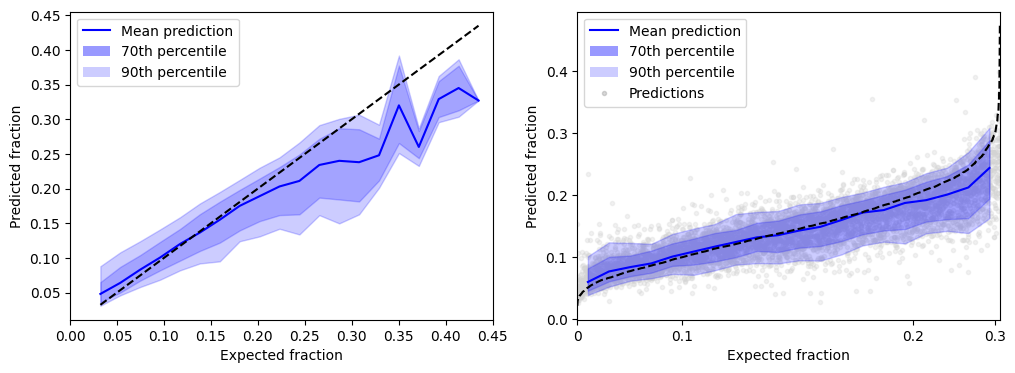

In [69]:

ordered = np.argsort(labels)[::-1]

X = labels[labels <= 0.45]
Y = predictions[labels <= 0.45]
n = 20
percentiles = [35, 45, 50]

# Calculation
calc_percent = []
for p in percentiles:
    if p < 50:
        calc_percent.append(50-p)
        calc_percent.append(50+p)
    elif p == 50:
        calc_percent.append(50)
    else:
        raise Exception('Percentile > 50')

bin_edges = np.linspace(X.min()*0.9999, X.max()*1.0001, n+1)

dtype = [(str(i), 'f') for i in calc_percent]
bin_data = np.zeros(shape=(n,), dtype=dtype)

empty_bins = []

for i in range(n):
    y = Y[(X >= bin_edges[i]) & (X < bin_edges[i+1])]

    if len(y) == 0:
        empty_bins.append(i)
        continue

    y_p = np.percentile(y, calc_percent)

    bin_data[i] = tuple(y_p)

# Plotting
plt.figure(figsize=(12,4))
plt.subplot(121)
ax = plt.gca()

bin_centers = [np.mean(bin_edges[i:i+2]) for i in range(n)]

# Remove empty bins
bin_data = np.delete(bin_data, empty_bins, 0)
for bin_num in empty_bins[::-1]: # in reverse order so indices are still valid
    bin_centers.pop(bin_num)

for p in percentiles:
    if p == 50:
        ax.plot(bin_centers, bin_data[str(p)], color='b')
    else:
        ax.fill_between(bin_centers,
                        bin_data[str(50-p)],
                        bin_data[str(50+p)],
                        alpha=0.2, color='b')

# Plot the expected line
ax.plot(np.linspace(bin_centers[0],bin_centers[-1],10),np.linspace(bin_centers[0],bin_centers[-1],10),'k--')
plt.xlim(0, 0.45)
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='b', label='Mean prediction'),
                    Patch(facecolor='b', alpha=0.4,
                        label='70th percentile'),
                    Patch(facecolor='b', alpha=0.2,
                        label='90th percentile')]
plt.legend(handles=legend_elements)

plt.xlabel('Expected fraction')
plt.ylabel('Predicted fraction')


#######################################
Y = predictions
X = np.arange(0, len(labels))

calc_percent = []
for p in percentiles:
    if p < 50:
        calc_percent.append(50-p)
        calc_percent.append(50+p)
    elif p == 50:
        calc_percent.append(50)
    else:
        raise Exception('Percentile > 50')

# indices = np.linspace(0, len(X)-1, n+1, dtype=int)
bin_edges = np.linspace(0, 5000, n+1)#np.linspace(X.min()*0.9999, X.max()*1.0001, n+1)
print(bin_edges)

dtype = [(str(i), 'f') for i in calc_percent]
bin_data = np.zeros(shape=(n,), dtype=dtype)

empty_bins = []

for i in range(n):
    y = Y[ordered][(X >= bin_edges[i]) & (X < bin_edges[i+1])]

    if len(y) == 0:
        empty_bins.append(i)
        continue

    y_p = np.percentile(y, calc_percent)

    bin_data[i] = tuple(y_p)

bin_centers = [np.mean(bin_edges[i:i+2]) for i in range(n)]

# Remove empty bins
bin_data = np.delete(bin_data, empty_bins, 0)
for bin_num in empty_bins[::-1]: # in reverse order so indices are still valid
    bin_centers.pop(bin_num)

plt.subplot(122)
ax = plt.gca()
plt.scatter(X[2:], Y[ordered][2:], marker='.', color='lightgray', alpha=0.3)

for p in percentiles:
    if p == 50:
        ax.plot(bin_centers, bin_data[str(p)], color='b')
    else:
        ax.fill_between(bin_centers,
                        bin_data[str(50-p)],
                        bin_data[str(50+p)],
                        alpha=0.2, color='b')

plt.plot(X[2:], labels[ordered][2:], 'k--')
# plt.fill_between(np.arange(0, len(labels)), labels[ordered]-0.04, labels[ordered]+0.04, alpha=0.2)
# plt.legend(['Target', 'Actual'])
sorted_labels = labels[ordered]
ticks = [5000, np.where(sorted_labels <= 0.1)[0][0], np.where(sorted_labels <= 0.2)[0][0], np.where(sorted_labels <= 0.3)[0][0]]
print(ticks)
plt.xticks(ticks, labels=[0, 0.1, 0.2, 0.3])
plt.xlabel('Expected fraction')
plt.ylabel('Predicted fraction') 
plt.xlim(5000, 0)
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='b', label='Mean prediction'),
                    Patch(facecolor='b', alpha=0.4,
                        label='70th percentile'),
                    Patch(facecolor='b', alpha=0.2,
                        label='90th percentile'), 
                    Line2D([0], [0], color='gray', alpha=0.3, marker='.', lw=0, label='Predictions')]
plt.legend(handles=legend_elements)
plt.show()

2023-10-12 19:18:53.276356: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [5000]
	 [[{{node Placeholder/_1}}]]


[   0  249  499  749  999 1249 1498 1748 1998 2248 2498 2747 2997 3247
 3497 3747 3996 4246 4496 4746 4996]
[0.02172067 0.06095296 0.07217919 0.08205693 0.09076377 0.10020392
 0.10908238 0.11739151 0.1256901  0.13421337 0.1419855  0.15012588
 0.15834913 0.1679065  0.17794631 0.18942262 0.20193681 0.21495935
 0.23104382 0.25830537 0.44539833]


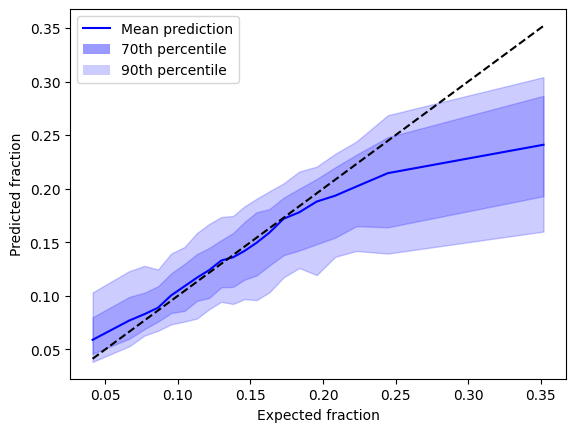

In [34]:
dataset = vd
Y = predictions
percentiles = [35, 45, 50]
n = 20

unbatched = dataset.unbatch()
    
labels = []
for i, thing in enumerate(unbatched):
    if thing[1] > 0.45:
        Y = np.delete(Y, i)
        continue
    labels.append(thing[1])
labels = np.array(labels)
X = np.sort(labels)
Y = Y[np.argsort(labels)]

# Calculation
calc_percent = []
for p in percentiles:
    if p < 50:
        calc_percent.append(50-p)
        calc_percent.append(50+p)
    elif p == 50:
        calc_percent.append(50)
    else:
        raise Exception('Percentile > 50')
indices = np.linspace(0, len(X)-1, n+1, dtype=int)
print(indices)
bin_edges = X[indices]#np.linspace(X.min()*0.9999, X.max()*1.0001, n+1)
print(bin_edges)

dtype = [(str(i), 'f') for i in calc_percent]
bin_data = np.zeros(shape=(n,), dtype=dtype)

empty_bins = []

for i in range(n):
    y = Y[(X >= bin_edges[i]) & (X < bin_edges[i+1])]

    if len(y) == 0:
        empty_bins.append(i)
        continue

    y_p = np.percentile(y, calc_percent)

    bin_data[i] = tuple(y_p)

# Plotting
f, ax = plt.subplots()

bin_centers = [np.mean(bin_edges[i:i+2]) for i in range(n)]

# Remove empty bins
bin_data = np.delete(bin_data, empty_bins, 0)
for bin_num in empty_bins[::-1]: # in reverse order so indices are still valid
    bin_centers.pop(bin_num)

for p in percentiles:
    if p == 50:
        ax.plot(bin_centers, bin_data[str(p)], color='b')
    else:
        ax.fill_between(bin_centers,
                        bin_data[str(50-p)],
                        bin_data[str(50+p)],
                        alpha=0.2, color='b')

# Plot the expected line
ax.plot(np.linspace(bin_centers[0],bin_centers[-1],10),np.linspace(bin_centers[0],bin_centers[-1],10),'k--')
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='b', label='Mean prediction'),
                    Patch(facecolor='b', alpha=0.4,
                        label='70th percentile'),
                    Patch(facecolor='b', alpha=0.2,
                        label='90th percentile')]
plt.legend(handles=legend_elements)

plt.xlabel('Expected fraction')
plt.ylabel('Predicted fraction')

plt.show()